In [107]:
%matplotlib inline
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=1)

In [108]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
import pylab as plt
from collections import defaultdict
import numpy as np
import regex as re
from collections import Counter

def letter_regex(k, size, regex_th=0.3):
    code=[]
    for letter, count in k:
        if count/float(size)>regex_th:
            if letter != '-':
                code.append(letter)
    if len(code)==1:
        code_str=code[0]
    else:
        code_str='('+'|'.join(code)+')'
    return code_str
            
def consensus_regex(trimmed_align_seqs, regex_th):
    cluster = []
    for h, align_seq in trimmed_align_seqs:
        str_list = [c for c in align_seq]
        concat_str = np.array(str_list, dtype=np.dtype('a'))
        cluster.append(concat_str)
    cluster = np.vstack(cluster)
    seq = ''
    size = len(trimmed_align_seqs)
    for i, row in enumerate(cluster.T):
        c = Counter(row)
        k = c.most_common()
    code=''
    for i, row in enumerate(cluster.T):
        c = Counter(row)
        k = c.most_common()    
        code += letter_regex(k, size, regex_th=regex_th)
    return code
    
def find_occurrences(needle, haystack):
    for h,s in haystack:
        matches = re.findall(needle, s, overlapped=True)
        if len(matches):
            yield 1
        else:
            yield 0
            
def num_occurrences(needle, haystack):
    s = sum(find_occurrences(needle, haystack))
    return s

def extract_consensus(test_pos_seqs, motives, regex_th):
    tot_num = len(test_pos_seqs)
    for cluster_id, consensus_seq, regex_seq, trimmed_align_seqs, align_seqs, seqs in motives: 
        counts =  num_occurrences(regex_seq, test_pos_seqs)
        freq = float(counts)/tot_num
        yield freq, cluster_id, regex_seq, counts, consensus_seq
        
def plot_location(needle, haystack, nbins=20, size=(17,2)):
    locs = []
    for h,s in haystack:
        for match in re.finditer(needle, s):
            s = match.start()
            e = match.end()
            m = s + (e-s)/2
            locs.append(m)
    plt.figure(figsize=size)
    n, bins, patches = plt.hist(locs, nbins, normed=0, facecolor='blue', alpha=0.3)
    plt.grid()
    plt.show()
    
def extract_location(needle, haystack):
    locs = []
    for h,s in haystack:
        for match in re.finditer(needle, s):
            s = match.start()
            e = match.end()
            m = s + (e-s)/2
            locs.append(m)
    avg_loc = np.mean(locs)
    std_loc = np.std(locs)
    return avg_loc, std_loc

def hits(clusters, ids=None):
    for i in ids:
        for h,s in clusters[i]:
            tokens = h.split('*')            
            seq_id = tokens[0]
            begin,end = tokens[1].split(':')
            yield (seq_id, int(begin), int(end), i)

def compute_cooccurence(clusters, ids=None):
    if ids is None:
        ids = [id for id in clusters]
    seqs_summary = defaultdict(list)
    for seq_id, begin, end, i in hits(clusters, ids=ids):
        seqs_summary[seq_id].append((begin, end, i))

    distances=defaultdict(list)
    size = max(id for id in clusters)+1
    cooccurence_mtx=np.zeros((size,size))   
    for seq_id in sorted(seqs_summary):
        cluster_ids = [cluster_id for begin, end, cluster_id in seqs_summary[seq_id]]
        centers = defaultdict(list)
        for begin, end, cluster_id in seqs_summary[seq_id]:
            centers[cluster_id].append(begin + (end - begin)/2)
        cluster_ids = set(cluster_ids)
        for i in cluster_ids:
            for j in cluster_ids:
                cooccurence_mtx[i,j]+=1
                if i != j:
                    # find closest instance j from  any instance in i
                    d_ij=[]
                    for c_i in centers[i]:
                        for c_j in centers[j]:
                            d_ij.append(abs(c_i - c_j)) 
                    selected_abs = min(d_ij)
                    for c_i in centers[i]:
                        for c_j in centers[j]:
                            if selected_abs == abs(c_i - c_j):
                                selected = c_i - c_j
                    distances[(i,j)].append(selected)
    cooccurence_mtx = np.nan_to_num(cooccurence_mtx)
    orig_cooccurence_mtx = cooccurence_mtx.copy()
    cooccurence_list = []
    for i,row in enumerate(cooccurence_mtx):
        norm = row[i]
        if norm != 0:
            row /= norm
        else:
            row = np.zeros(row.shape)
        row[i]=0
        cooccurence_list.append(row)
    norm_cooccurence_mtx=np.vstack(cooccurence_list)    
    return orig_cooccurence_mtx, norm_cooccurence_mtx, distances

def show_cooccurence(norm_cooccurence_mtx, fig_size=7):
    plt.figure( figsize=(fig_size,fig_size) )
    img = plt.imshow( norm_cooccurence_mtx, interpolation='none', cmap=plt.get_cmap( 'YlOrRd' ) )
    plt.xticks(range(len(norm_cooccurence_mtx)))
    plt.yticks(range(len(norm_cooccurence_mtx)))
    plt.show()    
    
def show_distances(distances, id_pairs=None, ids=None, nbins=5, size=(6,2)):
    def plot():
        if j>i:
            ds = distances[(i,j)]
            print i,j
            plt.figure(figsize=size)
            n, bins, patches = plt.hist(ds, nbins, normed=0, facecolor='green', alpha=0.3)
            plt.grid()
            plt.show()
    for i,j in distances:
        if id_pairs is not None:
            if (i,j) in id_pairs or (j,i) in id_pairs:
                plot()
        if ids is not None:
            if i in ids and j in ids:
                plot()

In [110]:
import GArDen.interfaces as garden
from GArDen.convert.sequence import SeqToPathGraph
from GArDen.transform.rna_structure import PathGraphToRNAPlfold

remap={'A0':'A','C0':'C','G0':'G','U0':'E','T0':'E',
       'A1':'V','C1':'S','G1':'Y','U1':'D','T1':'D'}

def remap_with_structure(pos_seqs, remap=remap):
    graphs = garden.transform(pos_seqs, program=SeqToPathGraph())
    graphs = garden.transform(graphs, program=PathGraphToRNAPlfold(max_num_edges=2,
                                                                   window_size=200,
                                                                   max_bp_span=100,
                                                                   hard_threshold=.5,
                                                                   avg_bp_prob_cutoff=.01))
    for graph in graphs:
        paireds = [graph.node[u]['label']+str(int(graph.node[u].get('paired',False))) for u in graph.nodes()]
        paireds = [remap[c] for c in paireds]
        seq = ''.join(paireds)
        yield ('ID',seq)
alphabet = 'protein'
color_scheme = 'chemistry'

In [111]:
def remap_with_structure(pos_seqs):
    for seq in pos_seqs:
        yield seq
alphabet = 'rna'
color_scheme = 'classic'

In [112]:
def filter_pvalue(iterable, threshold=2, less_than=False):
    for header,seq in iterable:
        val = float(header.split('_')[1])
        if less_than:
            if val < threshold:
                yield (header,seq)
        else:
            if val > threshold:
                yield (header,seq)

In [113]:
def filter_pvalue(iterable, threshold=2, less_than=False):
    for header,seq in iterable:
        val = float(header.split(';')[2])
        if less_than:
            if val < threshold:
                yield (header,seq)
        else:
            if val > threshold:
                yield (header,seq)

In [114]:
dir_name = '/Users/costa/Desktop/BTSync/DATA/RBP/'

In [115]:
#!ls  $dir_name

# SMoD

In [116]:
# good ones
name = 'HNRNPC-human_HepG2_ENCSR550DVK_rep1_unique_ids_extlr60_context0.fa'
name = 'HNRNPK-human_HepG2_ENCSR828ZID_rep1_unique_ids_extlr60_context0.fa'
name = 'KHDRBS1-human_K562_ENCSR628IDK_rep1_unique_ids_extlr60_context0.fa'
name = 'HNRNPA1-human_HepG2_ENCSR769UEW_rep1_unique_ids_extlr60_context0.fa'
name = 'PCBP2-human_HepG2_ENCSR339FUY_rep2_unique_ids_extlr60_context0.fa' #**
name = 'LIN28B-human_K562_ENCSR970NKP_rep2_unique_ids_extlr60_context0.fa'
name = 'GTF2F1-human_HepG2_ENCSR265ZIS_rep1_unique_ids_extlr60_context0.fa'
pos_fname = dir_name+name

In [117]:
name = 'FMR1-human_K562_ENCSR331VNX_rep1_unique_ids_extlr60_context0.fa'
name = 'QKI-human_HepG2_ENCSR570WLM_rep1_unique_ids_extlr60_context0.fa'
name = 'IGF2BP3-human_HepG2_ENCSR993OLA_rep1_unique_ids_extlr60_context0.fa'
name = 'U2AF2-human_HepG2_ENCSR202BFN_rep1_unique_ids_extlr60_context0.fa'
pos_fname = dir_name+name

In [118]:
complexity=5 #feature resolution
n_clusters=20 # maximal num of motives; tradeoff: if high -> small omogenous motives, if low -> few mixed motives
min_subarray_size = 5
max_subarray_size = 10
# merging parameters
similarity_threshold=0.5
min_score=5
min_freq=0.6
min_cluster_size=10
#filtering parameters
display_th = 0.01 # minimum frequency of a consensus regex to be displayed
regex_th=0.25 # minimum frequency of a nt to be included in the consensus regex 
th_std = 29 # maximum std of localization of consensus regex within the sequence

In [119]:
desired_size=2500
min_diff=desired_size
for th in np.linspace(2.0, 5.5, num=15):
    from eden.converter.fasta import fasta_to_sequence
    pos_seqs = fasta_to_sequence(pos_fname)
    pos_seqs = filter_pvalue(pos_seqs,threshold=th)
    from eden.util import iterator_size
    num = iterator_size(pos_seqs)
    diff = abs(num-desired_size)
    if diff < min_diff:
        min_diff = diff
        min_th = th
    print 'fold_change_th: %.1f  selected seqs:%.6d  diff_to_desired: %.6d'%(th, num , diff)
th = min_th
print 'Selected threshold %.1f' % th

fold_change_th: 2.0  selected seqs:030473  diff_to_desired: 027973
fold_change_th: 2.2  selected seqs:027335  diff_to_desired: 024835
fold_change_th: 2.5  selected seqs:021774  diff_to_desired: 019274
fold_change_th: 2.8  selected seqs:016998  diff_to_desired: 014498
fold_change_th: 3.0  selected seqs:013039  diff_to_desired: 010539
fold_change_th: 3.2  selected seqs:010014  diff_to_desired: 007514
fold_change_th: 3.5  selected seqs:007348  diff_to_desired: 004848
fold_change_th: 3.8  selected seqs:005013  diff_to_desired: 002513
fold_change_th: 4.0  selected seqs:003274  diff_to_desired: 000774
fold_change_th: 4.2  selected seqs:002190  diff_to_desired: 000310
fold_change_th: 4.5  selected seqs:001313  diff_to_desired: 001187
fold_change_th: 4.8  selected seqs:000789  diff_to_desired: 001711
fold_change_th: 5.0  selected seqs:000413  diff_to_desired: 002087
fold_change_th: 5.2  selected seqs:000224  diff_to_desired: 002276
fold_change_th: 5.5  selected seqs:000109  diff_to_desired: 00

In [120]:
%%time
from eden.converter.fasta import fasta_to_sequence
pos_seqs = fasta_to_sequence(pos_fname)
pos_seqs = filter_pvalue(pos_seqs,threshold=th)
pos_seqs = remap_with_structure(pos_seqs)
pos_seqs=list(pos_seqs)

#neg_seqs = fasta_to_sequence(neg_fname)
from eden.converter.fasta import fasta_to_sequence
neg_seqs = fasta_to_sequence(pos_fname)
neg_seqs = filter_pvalue(neg_seqs,threshold=th)
neg_seqs = remap_with_structure(neg_seqs)
from eden.modifier.seq import seq_to_seq, shuffle_modifier
neg_seqs = seq_to_seq(neg_seqs, modifier=shuffle_modifier, times=2, order=1)
neg_seqs_ord1 = list(neg_seqs)

from eden.converter.fasta import fasta_to_sequence
neg_seqs = fasta_to_sequence(pos_fname)
neg_seqs = filter_pvalue(neg_seqs,threshold=th)
neg_seqs = remap_with_structure(neg_seqs)
from eden.modifier.seq import seq_to_seq, shuffle_modifier
neg_seqs = seq_to_seq(neg_seqs, modifier=shuffle_modifier, times=1, order=2)
neg_seqs_ord2 = list(neg_seqs)

neg_seqs = neg_seqs_ord1 + neg_seqs_ord2

CPU times: user 4.2 s, sys: 50.1 ms, total: 4.25 s
Wall time: 4.29 s


In [121]:
%%time
pos_size = len(pos_seqs)
train_pos_seqs = pos_seqs[:pos_size/2]
test_pos_seqs = pos_seqs[pos_size/2:]

neg_size = len(neg_seqs)
train_neg_seqs = neg_seqs[:neg_size/2]
test_neg_seqs = neg_seqs[neg_size/2:]

pos_block_size = pos_size / 16
neg_block_size = neg_size / 16


from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
smod=SMoD(complexity=complexity,
          n_clusters=n_clusters,
          min_subarray_size=min_subarray_size,
          max_subarray_size=max_subarray_size,
          pos_block_size=pos_block_size,
          neg_block_size=neg_block_size)
smod = smod.fit(train_pos_seqs, train_neg_seqs)
smod.performance(test_pos_seqs, test_neg_seqs)

Confusion matrix:
[[2831  449]
 [ 175  913]]
Classification:
             precision    recall  f1-score   support

         -1       0.94      0.86      0.90      3280
          1       0.67      0.84      0.75      1088

avg / total       0.87      0.86      0.86      4368

ROC: 0.926
CPU times: user 756 ms, sys: 407 ms, total: 1.16 s
Wall time: 1min 20s


In [122]:
%%time
orig_clusters = smod.predict(test_pos_seqs)

CPU times: user 1.45 s, sys: 259 ms, total: 1.71 s
Wall time: 36.2 s


In [123]:
%%time
clusters, motives = smod.merge(orig_clusters, 
                               similarity_threshold=similarity_threshold,
                               min_score=min_score,
                               min_freq=min_freq,
                               min_cluster_size=min_cluster_size)

CPU times: user 1.23 s, sys: 779 ms, total: 2.01 s
Wall time: 12.5 s



High quality motives: # 2

07                    UUUUU(U|C)(U|C)(C|U)U #0275 0.25  UUUUUUCU 0.10  UUUUUUUC 0.14
00                     UUU(U|C)C(A|C)(G|A)G #0061 0.06  UUUCAGG 0.04  UUUUCAG 0.06

Cluster id: 7  (# seqs: 162) cons: UUUUUUUCU  regex: UUUUU(U|C)(U|C)(C|U)U
UUUUUUUCU


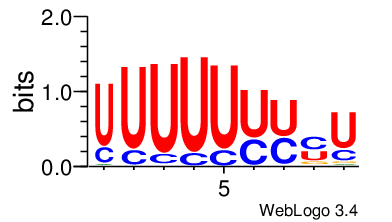

Cluster id: 0  (# seqs: 112) cons: UUUUCAGG  regex: UUU(U|C)C(A|C)(G|A)G
UUUUCAGG


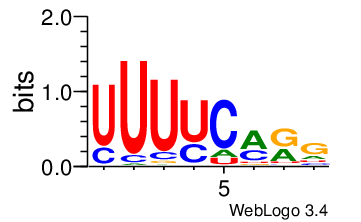


35.3226837061 20.9830609414
---------------------------------------------------------------------------------------------------------------------
7 UUUUUUUCU UUUUU(U|C)(U|C)(C|U)U 275 0.251141552511


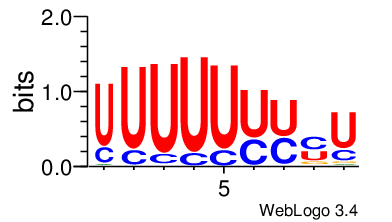

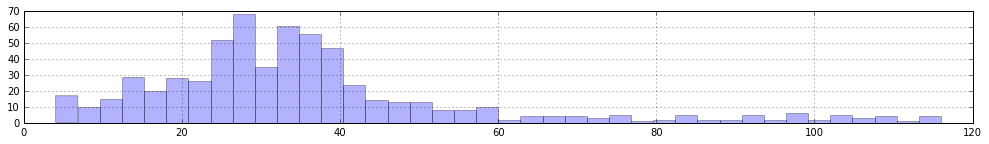

57.5079365079 25.4420430795
---------------------------------------------------------------------------------------------------------------------
0 UUUUCAGG UUU(U|C)C(A|C)(G|A)G 61 0.0557077625571


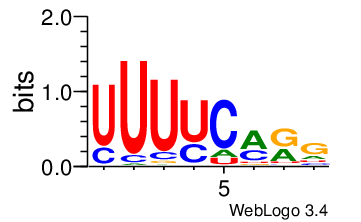

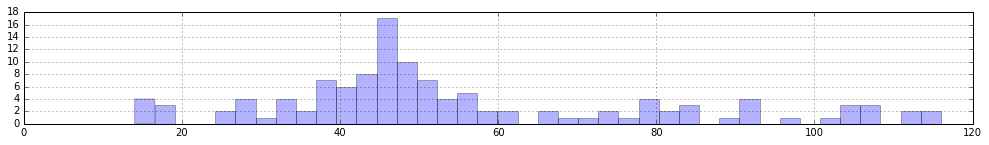

In [124]:
display_th = 0.035 # minimum frequency of a consensus regex to be displayed
regex_th=0.25 # minimum frequency of a nt to be included in the consensus regex 
th_std = 33 # maximum std of localization of consensus regex within the sequence

clusters, motives = smod.frequency_filter(test_pos_seqs, motives, freq_threshold=display_th)
print
print 'High quality motives: # %d' % len(motives)
print


ids=[]
tot_num = len(test_pos_seqs)
for freq, cluster_id, c_regex, counts,consensus_seq  in sorted(extract_consensus(test_pos_seqs, motives, regex_th), reverse=True):
    if freq > display_th:
        l_cons = consensus_seq[1:]
        r_cons = consensus_seq[:-1]
        n_l_cons = num_occurrences(l_cons, test_pos_seqs)/float(tot_num)
        n_r_cons = num_occurrences(r_cons, test_pos_seqs)/float(tot_num)
        print '%.2d %40s #%.4d %.2f  %7s %.2f  %7s %.2f' % (cluster_id, c_regex, counts, freq, l_cons, n_l_cons, r_cons, n_r_cons)
        ids.append(cluster_id)
print
selected_ids = [cluster_id for freq, cluster_id, _, _,_ in sorted(extract_consensus(test_pos_seqs, motives, regex_th), reverse=True) if freq > display_th]
logos = smod.display_logos(motives, selected_ids)

print

from IPython.display import Image, display
for freq, cluster_id, c_regex, counts,consensus_seq in sorted(extract_consensus(test_pos_seqs, motives, regex_th), reverse=True):
    if freq > display_th:
        avg,std = extract_location(c_regex, test_pos_seqs)
        print avg,std
        if std <th_std:
            print '-'*117
            if  c_regex != consensus_seq:
                print cluster_id, consensus_seq, c_regex, counts, freq
            else:
                print cluster_id, consensus_seq, counts, freq
            display(Image(logos[cluster_id]))
            plot_location(c_regex, pos_seqs, nbins=40, size=(17,2))   

In [127]:
# plot co-occurrence counts 

from IPython.display import Image, display


def compute_avg_fold_change(id, clusters):
    return np.mean([float(h.split('_')[1].split('*')[0]) for h,s in clusters[id]])
def compute_avg_fold_change(id, clusters):
    return np.mean([float(h.split(';')[2].split('*')[0]) for h,s in clusters[id]])


cooccurence_mtx, norm_cooccurence_mtx, distances = compute_cooccurence(clusters, ids=selected_ids)
cos = sorted([(norm_cooccurence_mtx[i,j], i,j, cooccurence_mtx[i,j]) for i,j in distances],reverse=True)
num = min(len(cos),5)
for v, i, j, u in cos[:num]:
    if v > .3 and u > 10: #in more than a third of occurrences
        fg_i = compute_avg_fold_change(i, clusters)
        fg_j = compute_avg_fold_change(j, clusters)

        print 'co-occurs: %.2f (#%d) cl:%d (avg. fold change: %.1f)  cl:%d (avg. fold change: %.1f)'%(v,u, i, fg_i, j, fg_j)
        display(Image(logos[i]))
        display(Image(logos[j]))
        id_pairs=[(i,j)]
        show_distances(distances, id_pairs=id_pairs, ids=None, nbins=20, size=(17,2))
        print '='*117
        print '\n\n'

Exact pattern UUUUUUUC occurs 303 times in 2190 seqs (0.14)


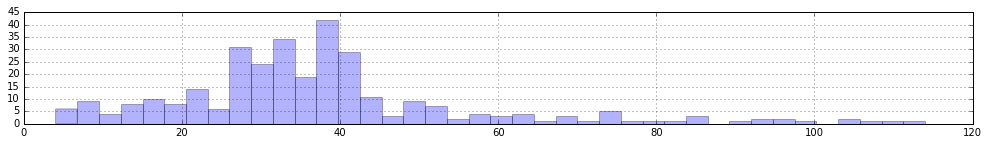

0 U2AF2-human_HepG2_ENCSR202BFN_rep1_00010;chr1:100081962-100082083,+;4.38285310726216
GUAUUUGUGUAAAAAUCCUAAUUACUUUAUUCUUCCUCAGAAUUCCAUCAUCCCUGGCCCUCCCUUCCUAUUUGGAGCCUGUUCAGUACUGCUGGCUCUGCUUGUUGCCUUGUUUAUUCCG

1 U2AF2-human_HepG2_ENCSR202BFN_rep1_00034;chr1:10072404-10072525,+;4.63078062070575
ACCAAUUGCUUUUCUUUCCAUAACUUCCAUCUUUUUUUUUUUCAAACAGGUUUAGGUAUUAUCUCUGAUGACAAGAUGAUUAAGACUGAAUUUGGUUCUGCUGAUUUUAUGAAUUUGGUUG

0 U2AF2-human_HepG2_ENCSR202BFN_rep1_00038;chr1:100877832-100877953,-;4.38285310726216
GGACUCGUAAGAAUGCUAACAUUUGUAUGUUGUUUCCAUUUCUACUCCAGGUGUUGCCACAUCUGCAAACUUCCUGGGAGAGUAAUGGGGAUUCGAGUGCUUCGAUUAUCUUUGGUGGUCA

1 U2AF2-human_HepG2_ENCSR202BFN_rep1_00059;chr1:10126759-10126880,+;4.42724722662062
ACUUAUAUUUCUGAUUUUGUUUUUUUUCUUAUAGAUAUUUAUCCCCAUUUUACAAGGCCUGGCUCUUGCUGCCAAAGAGUGCUCCCUCGACAGUGACUACUUUAAAUACCCCCUCAUGGUA

0 U2AF2-human_HepG2_ENCSR202BFN_rep1_00204;chr1:109584570-109584691,+;4.33704941764904
GAUAUCUUGUUAUGAAGUACUAUCAUUUCUUCCUUUUCCUCUUCUCUCUAGGCAAAACUACUAUCCAUUUAUUCAAA

In [131]:
# identify exact occurrence of user defined sequence in pos seqs

def split_occurrences(needle, haystack, col=60):
    for h,s in haystack:
        delim="\x1b[33m"+needle+"\x1b[0m"
        #delim=' '
        sp = re.split(needle, s, overlapped=True)
        print len(sp)-1, h
        seq = delim.join(sp)
        print seq
        print

needle = 'UUUUUUUC'
n_occ = num_occurrences(needle, pos_seqs)
print 'Exact pattern %s occurs %d times in %d seqs (%.2f)' % (needle,n_occ , len(pos_seqs), float(n_occ)/len(pos_seqs))
plot_location(needle, pos_seqs, nbins=40, size=(17,2))
split_occurrences(needle, pos_seqs)

---